<a href="https://colab.research.google.com/github/Alexandre77777/data_mining/blob/main/8.%20%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B2%D1%8B%D0%B5%20%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B%20%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE%20%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0%20%E2%84%9611.%20%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B5%D0%B2%D1%8B%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%BC%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучить модели машинного обучения для решения задачи классификации, используя следующие boosting-алгоритмы: CatBoost, Light GBM, XGBoost, AdaBoost. Сравнить их точность и быстродействие.

Датасет: https://www.kaggle.com/c/titanic/data

In [3]:
!pip install catboost lightgbm xgboost

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import time
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Считывание и подготовка данных

In [5]:
df = pd.read_csv('./notebooks/data/titanic/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# df['Cabin'] = list(map(lambda x: x[0], list(df.Cabin[df.Cabin.notnull()])))

In [7]:
# Единственный человек с палубы T?? 
df[(df.Cabin.notnull()) & (df.Cabin.notna()) & (df.Cabin.str.contains('T'))] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


Колонки Age, Cabin, Embarked

Колонку Sex пропустим через LabelBinarizer.
Отфильтруем данные, в которых Age не None
Преобразуем Age к Int

Следующие колонки мы уберем как малозначимые:
PassengerId - id пассажира, 
Name - имя пассажира, 
Fare - стоимость билета, 
SibSp - количество сестер/братьев, 
Parch - количество родителей, 
Cabin - каюта (т.к. из з 889 только у 204 она прописана), 
Embarked - откуда высадились на корабль, 
Ticket - номер билета

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
from sklearn.preprocessing import LabelEncoder

df_cleaned = df.copy()

mean_age = df_cleaned['Age'].mean()
std_age = df_cleaned['Age'].std()
null_age_count = df_cleaned['Age'].isnull().sum()
random_ages = np.random.randint(mean_age - std_age, mean_age + std_age, size=null_age_count)
df_cleaned.loc[np.isnan(df_cleaned['Age']), 'Age'] = random_ages

sex_encoder = LabelEncoder()
df_cleaned['Sex'] = sex_encoder.fit_transform(df_cleaned['Sex'])
df_cleaned['Age'] = df_cleaned['Age'].astype('int64')

df_columns = ['Survived', 'Pclass', 'Sex', 'Age']
df_cleaned = df_cleaned[df_columns]

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
dtypes: int64(4)
memory usage: 28.0 KB


In [10]:
x_columns = ['Pclass', 'Sex', 'Age']
y_column = ['Survived']

X = df_cleaned[x_columns]
y = df_cleaned[y_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение

In [11]:
# Инициализация и обучение моделей
models = {
    "CatBoost": CatBoostClassifier(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

In [12]:
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time()

    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

# Вывод результатов
for name, metrics in results.items():
    print(f"Модель: {name}")
    for metric, value in metrics.items():
        print(f'{metric} - {value}')
    print("---------------------")

Learning rate set to 0.008911
0:	learn: 0.6878664	total: 47.9ms	remaining: 47.9s
1:	learn: 0.6827032	total: 48.8ms	remaining: 24.3s
2:	learn: 0.6776470	total: 49.5ms	remaining: 16.4s
3:	learn: 0.6720854	total: 50.4ms	remaining: 12.5s
4:	learn: 0.6662968	total: 51.3ms	remaining: 10.2s
5:	learn: 0.6615750	total: 52ms	remaining: 8.61s
6:	learn: 0.6569535	total: 52.7ms	remaining: 7.48s
7:	learn: 0.6523620	total: 53.5ms	remaining: 6.64s
8:	learn: 0.6478741	total: 54.4ms	remaining: 5.99s
9:	learn: 0.6429739	total: 55.2ms	remaining: 5.46s
10:	learn: 0.6385880	total: 56.2ms	remaining: 5.05s
11:	learn: 0.6344636	total: 56.9ms	remaining: 4.69s
12:	learn: 0.6295178	total: 57.8ms	remaining: 4.39s
13:	learn: 0.6255373	total: 58.7ms	remaining: 4.13s
14:	learn: 0.6214164	total: 59.5ms	remaining: 3.9s
15:	learn: 0.6167468	total: 60.3ms	remaining: 3.71s
16:	learn: 0.6130739	total: 61ms	remaining: 3.52s
17:	learn: 0.6086906	total: 61.9ms	remaining: 3.38s
18:	learn: 0.6043088	total: 62.8ms	remaining: 3.2

/home/flexlug/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/flexlug/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/flexlug/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Выведем матрицы ошибок

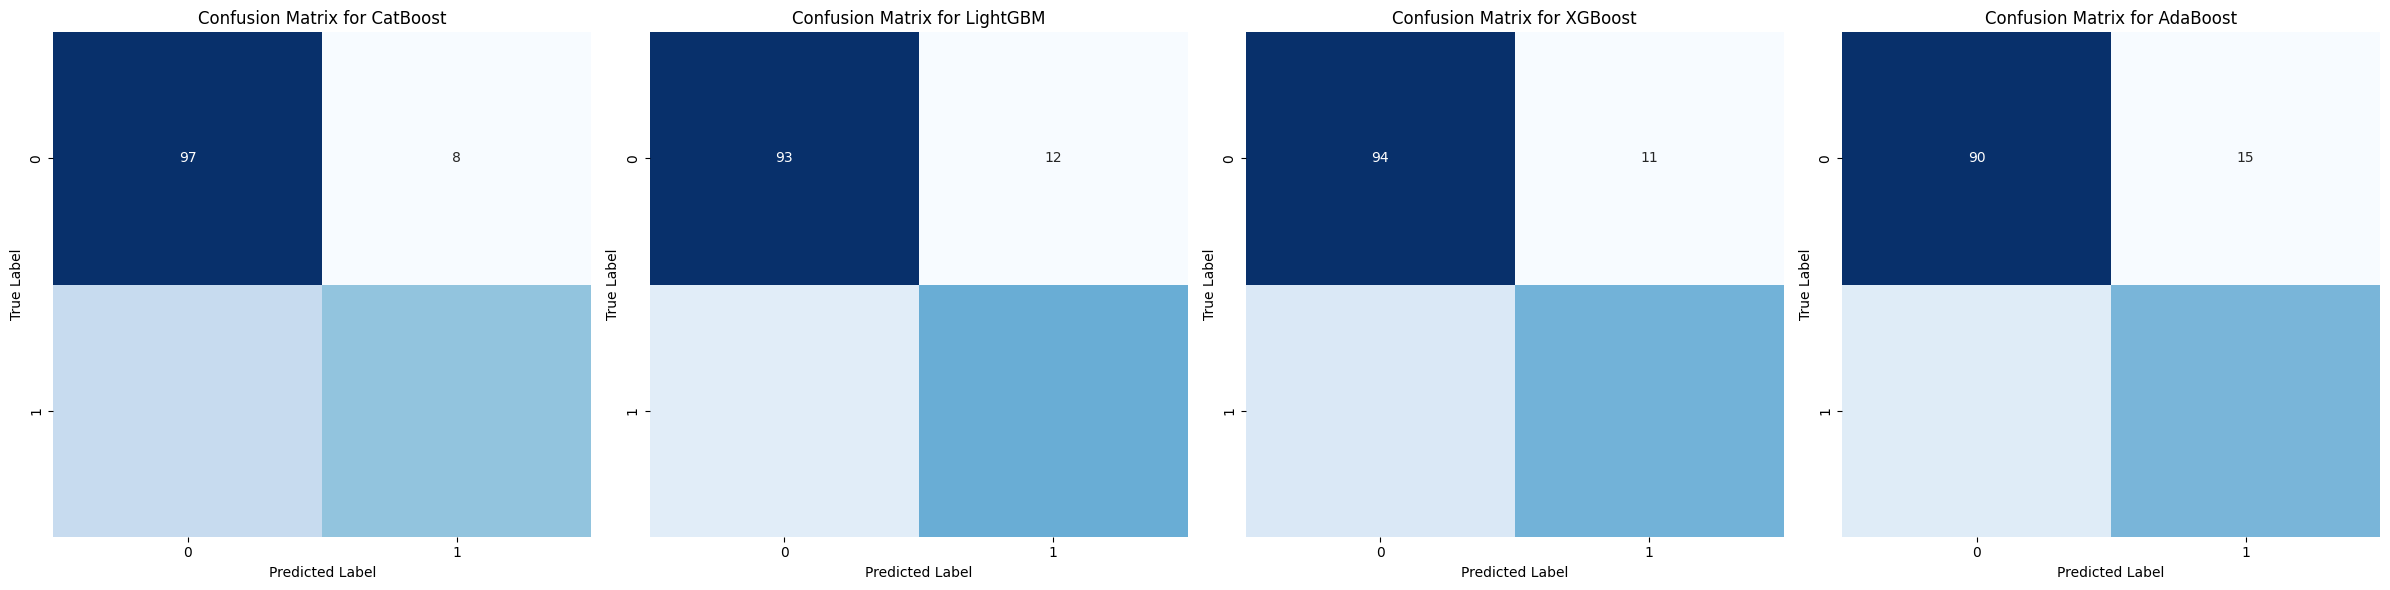

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

num_models = len(results)
fig, axes = plt.subplots(ncols=num_models, figsize=(6*num_models, 6))

# Постройте тепловую карту для каждой матрицы ошибок
for i, (model, metrics) in enumerate(results.items()):
    ax = axes[i]
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f'Confusion Matrix for {model}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig.tight_layout()
fig.show()

Выведем графики по каждой метрике

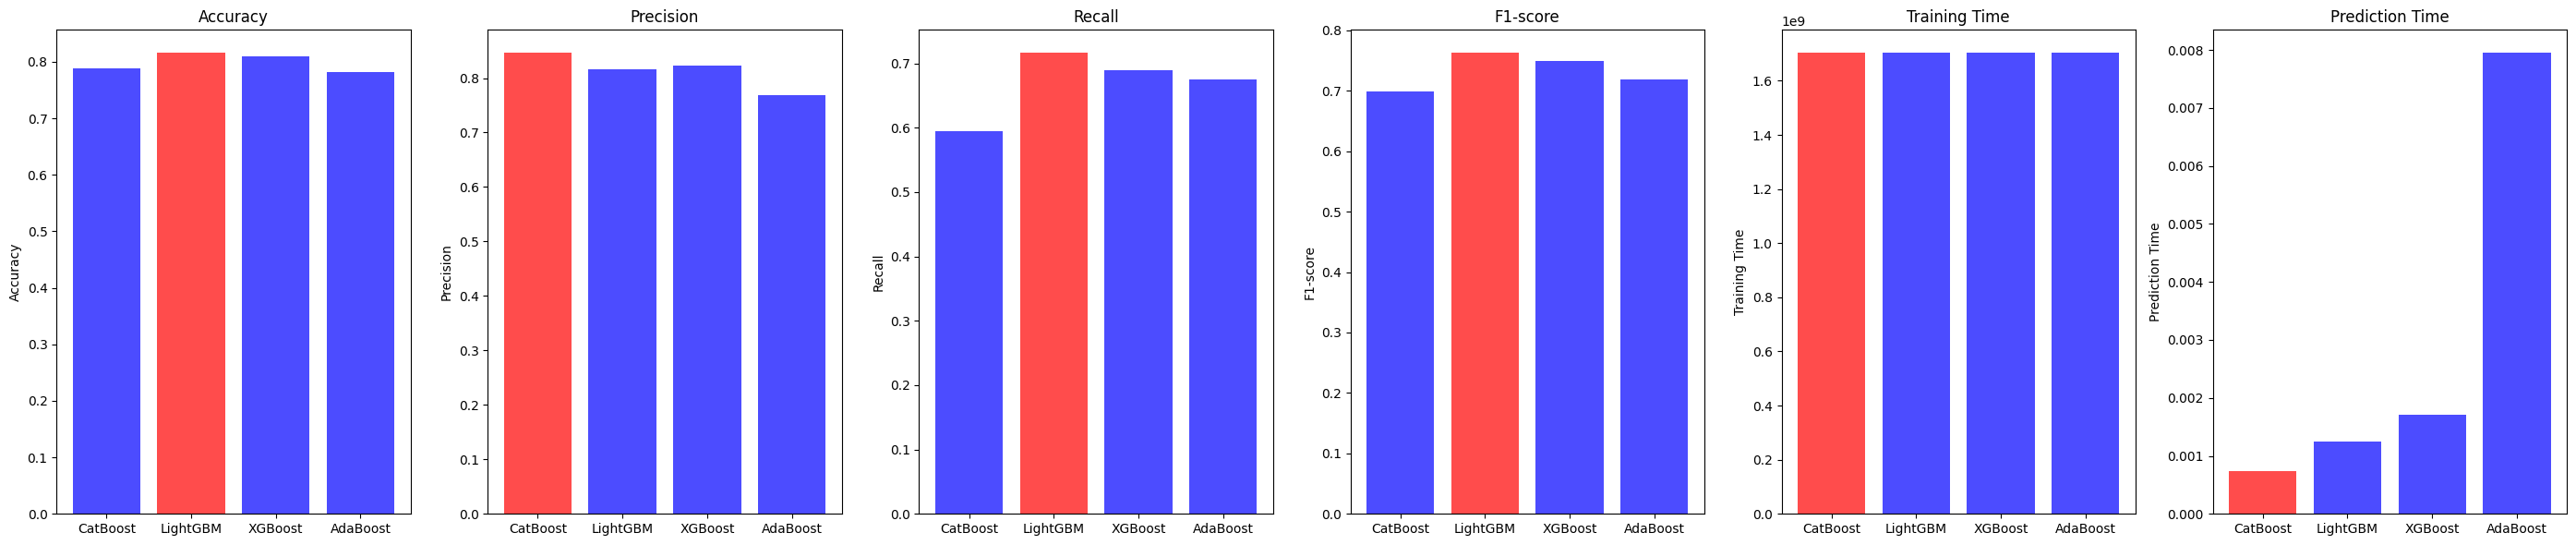

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

models = list(results.keys())
assert len(models) != 0
metrics = list(results[models[0]].keys())
metrics.remove('Confusion Matrix')
num_metrics = len(metrics)
fig, axes = plt.subplots(ncols=num_metrics, figsize=(28, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [results[model][metric] for model in models]

    # Prediction time - less is better
    # Other - more are better
    if metric in ['Prediction Time', 'Training Time']:
        best_model_index = values.index(min(values))
    else:
        best_model_index = values.index(max(values))

    colors = ['red' if j == best_model_index else 'blue' for j in range(len(models))]
    
    ax.bar(models, values, color=colors, alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')

fig.tight_layout()
fig.show()

# Обучить модели машинного обучения для решения задачи **регрессии**, используя следующие boosting-алгоритмы: [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor), [Light GBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html), [XGBoost](https://kirenz.github.io/regression/docs/xgboost-regression.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html). Сравнить их точность и быстродействие.

Датасет: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html

In [57]:
from sklearn.datasets import fetch_olivetti_faces

# Загрузка данных
faces_data = fetch_olivetti_faces()

# Просмотр информации о данных
print(faces_data.DESCR)

# Получение изображений и меток
images = faces_data.images
target = faces_data.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/flexlug/scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for 

In [58]:
from sklearn.model_selection import train_test_split
import numpy as np

X = images.reshape(len(images), -1)
y = target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

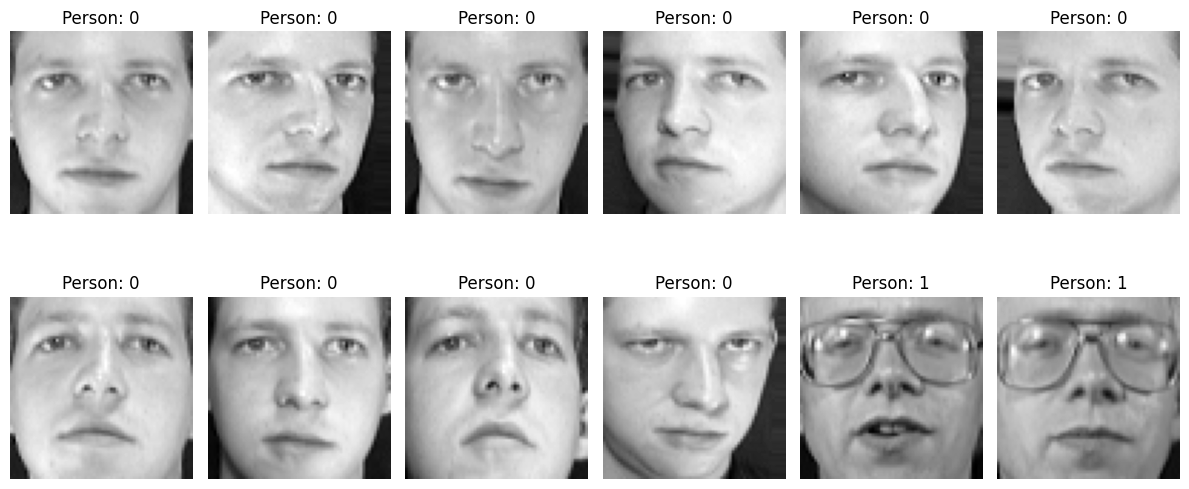

In [59]:
import matplotlib.pyplot as plt


num_samples = 12

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples // 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Person: {target[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [60]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
import time
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

In [61]:
models = {
    "CatBoost": CatBoostRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

In [62]:
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    predict_time = time.time() - start_time

    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    explained_variance = explained_variance_score(y_test, predictions)

    results[name] = {
        "MAE": mae,
        "R^2": r2,
        "Explained Variance": explained_variance,
        "Training Time": train_time,
        "Prediction Time": predict_time
    }

for name, metrics in results.items():
    print(f"Модель: {name}")
    for metric, value in metrics.items():
        print(f'{metric} - {value}')
    print("---------------------")

Learning rate set to 0.034197
0:	learn: 11.1554296	total: 147ms	remaining: 2m 26s
1:	learn: 11.0237663	total: 276ms	remaining: 2m 17s
2:	learn: 10.8945045	total: 405ms	remaining: 2m 14s
3:	learn: 10.8202903	total: 535ms	remaining: 2m 13s
4:	learn: 10.6994209	total: 663ms	remaining: 2m 12s
5:	learn: 10.5834543	total: 804ms	remaining: 2m 13s
6:	learn: 10.4679881	total: 934ms	remaining: 2m 12s
7:	learn: 10.3462737	total: 1.06s	remaining: 2m 11s
8:	learn: 10.2290078	total: 1.19s	remaining: 2m 11s
9:	learn: 10.1153048	total: 1.32s	remaining: 2m 11s
10:	learn: 10.0279283	total: 1.45s	remaining: 2m 10s
11:	learn: 9.9446018	total: 1.58s	remaining: 2m 10s
12:	learn: 9.8580568	total: 1.72s	remaining: 2m 10s
13:	learn: 9.7806754	total: 1.85s	remaining: 2m 10s
14:	learn: 9.6832615	total: 1.98s	remaining: 2m 9s
15:	learn: 9.5915845	total: 2.11s	remaining: 2m 9s
16:	learn: 9.4989628	total: 2.24s	remaining: 2m 9s
17:	learn: 9.4014354	total: 2.37s	remaining: 2m 9s
18:	learn: 9.2775032	total: 2.5s	rema

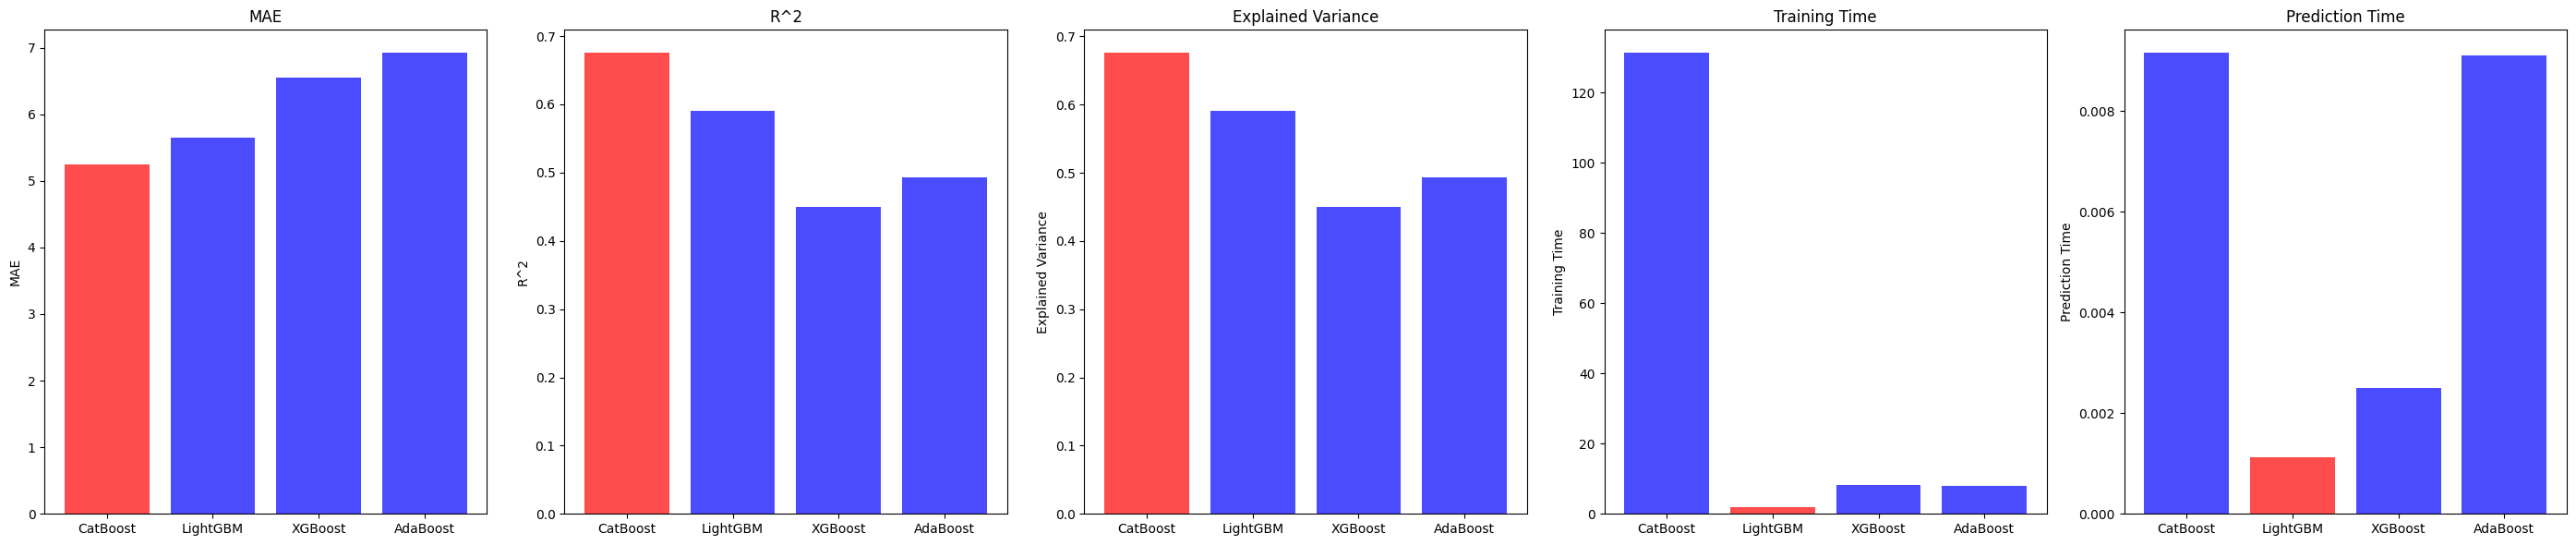

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

models = list(results.keys())
assert len(models) != 0
metrics = list(results[models[0]].keys())
num_metrics = len(metrics)
fig, axes = plt.subplots(ncols=num_metrics, figsize=(28, 6))

for i, metric in enumerate(metrics):
    ax = axes[i]
    values = [results[model][metric] for model in models]

    # Prediction time - less is better
    # Other - more are better
    if metric in ['MAE', 'Training Time', 'Prediction Time']:
        best_model_index = values.index(min(values))
    else:
        best_model_index = values.index(max(values))

    colors = ['red' if j == best_model_index else 'blue' for j in range(len(models))]
    
    ax.bar(models, values, color=colors, alpha=0.7)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric}')

fig.tight_layout()
fig.show()